## IS453 Financial Analytics
## Week 9 - Credit Scoring Lab

### Data Preparation and Logistic Regression

## HMEQ Dataset

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. 
The data is originally taken from the Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS book website - https://www.bartbaesens.com/book/6/credit-risk-analytics.
A cleaner version of the data is on Kaggle - https://www.kaggle.com/akhil14shukla/loan-defaulter-prediction/data


**Variables definition**

1. BAD: Binary response variable
    - 1 = applicant defaulted on loan or seriously delinquent; 
    - 0 = applicant paid loan or customer is current on loan payments. This is the class column.
2. LOAN: Requested loan amount
3. MORTDUE: Amount due on existing mortgage
4. VALUE: Value of current property
5. REASON: 
    - DebtCon = debt consolidation(customer uses home equity loan to pay back high interest loans)
    - HomeImp = home improvement
6. JOB: Occupational categories
    - ProfExe
    - Mgr
    - Office
    - Self
    - Sales
    - Other
7. YOJ: Years at present job
8. DEROG: Number of major derogatory reports(issued for loans taken in the past when customer fails to keep up the contract or payback on time).
9. DELINQ: Number of delinquent credit lines
10. CLAGE: Age of oldest credit line in months
11. NINQ: Number of recent credit inquiries
12. CLNO: Number of credit lines
13. DEBTINC: Debt-to-income ratio in percent

In [1]:
# sample code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:

# sample code

hmeq_data = pd.read_csv('hmeq_data.csv')

# make a copy of the original data for reference
hmeq_data_orig = hmeq_data.copy()

hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


## 1. Data preparation

Because we are going to test using logistic regression as a predictive model, we cannot have any missing values in the data. So will remove any rows with missing values. 

**This would NOT be a good thing to do in practice.**

In [3]:
# sample code
# note: when you run this cell, hmeq_data will be changed

# drop rows based on a threshold value of at 1 or more missing values
rows_org = hmeq_data.shape[0]
print(f'Starting row count: {rows_org:,.0f}')

# drop rows based on a threshold of 1 or more missing values per row
hmeq_data = hmeq_data.dropna(thresh = hmeq_data.shape[1] - 0)
print(f'Ending row count: {hmeq_data.shape[0]:,.0f}')
print(f'Percent dropped: {(1 - hmeq_data.shape[0] / rows_org):.2%}')

Starting row count: 5,960
Ending row count: 3,364
Percent dropped: 43.56%


Check the value counts for all the fields, should be the same now.

In [4]:
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3364 entries, 5 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3364 non-null   int64  
 1   LOAN     3364 non-null   int64  
 2   MORTDUE  3364 non-null   float64
 3   VALUE    3364 non-null   float64
 4   REASON   3364 non-null   object 
 5   JOB      3364 non-null   object 
 6   YOJ      3364 non-null   float64
 7   DEROG    3364 non-null   float64
 8   DELINQ   3364 non-null   float64
 9   CLAGE    3364 non-null   float64
 10  NINQ     3364 non-null   float64
 11  CLNO     3364 non-null   float64
 12  DEBTINC  3364 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 367.9+ KB


**Remove categorical variables**

Because we are going to test using logistic regression as a predictive model, we cannot include categorical values in the data. So will remove the categorical data columns.

**This would NOT be a good thing to do in practice.**

In [5]:
# sample code
hmeq_data = hmeq_data.drop(['REASON','JOB'], axis = 1)
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3364 entries, 5 to 5959
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3364 non-null   int64  
 1   LOAN     3364 non-null   int64  
 2   MORTDUE  3364 non-null   float64
 3   VALUE    3364 non-null   float64
 4   YOJ      3364 non-null   float64
 5   DEROG    3364 non-null   float64
 6   DELINQ   3364 non-null   float64
 7   CLAGE    3364 non-null   float64
 8   NINQ     3364 non-null   float64
 9   CLNO     3364 non-null   float64
 10  DEBTINC  3364 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 315.4 KB


**Ex Q1:**

What some reasons why it would be bad to drop rows with missing values and categorical column values?

Some values may be useful to determine how likely a borrower is likely to default. For example, if the borrower does not have a job, or have 0 income, it should have some correlation to their ability to service their loans. Removing these values can handicap our resulting model. 

**Identify and drop invalid outliers**

Only remove the outliers that are impossible values.

In [6]:
# sample code 

# which maximum value looks impossible?
hmeq_data.select_dtypes('number').max().map('{:,.0f}'.format)

BAD              1
LOAN        89,900
MORTDUE    399,412
VALUE      512,650
YOJ             41
DEROG           10
DELINQ          10
CLAGE        1,168
NINQ            13
CLNO            64
DEBTINC        144
dtype: object

In [7]:
# sample code

# maximum reasonable CLAGE = 80 years * 12 months = 960 months
max_clage = 80 * 12

# find rows that exceed that threshold
hmeq_data[hmeq_data['CLAGE'] > max_clage]

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3679,1,19300,96454.0,157809.0,3.0,0.0,0.0,1168.233561,0.0,0.0,40.206138


In [8]:
# sample code

# check number of rows before, drop those rows, and then check after
print(hmeq_data.shape[0])
hmeq_data.drop(hmeq_data[hmeq_data['CLAGE'] > max_clage].index, inplace=True)
print(hmeq_data.shape[0])

3364
3363


**Ex Q2: check for highly correlated variables**

Including highly correlated variable in the input data will cause problems for the logistic regression model. 

Find variables have a correlation value of > 0.8 <BR>
Of those variables, drop the one with the lower correlation to BAD
- Which one did you drop?
- Why do we want to drop highly correlated variables?

<class 'pandas.core.frame.DataFrame'>
Index: 3363 entries, 5 to 5959
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3363 non-null   int64  
 1   LOAN     3363 non-null   int64  
 2   VALUE    3363 non-null   float64
 3   YOJ      3363 non-null   float64
 4   DEROG    3363 non-null   float64
 5   DELINQ   3363 non-null   float64
 6   CLAGE    3363 non-null   float64
 7   NINQ     3363 non-null   float64
 8   CLNO     3363 non-null   float64
 9   DEBTINC  3363 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 289.0 KB


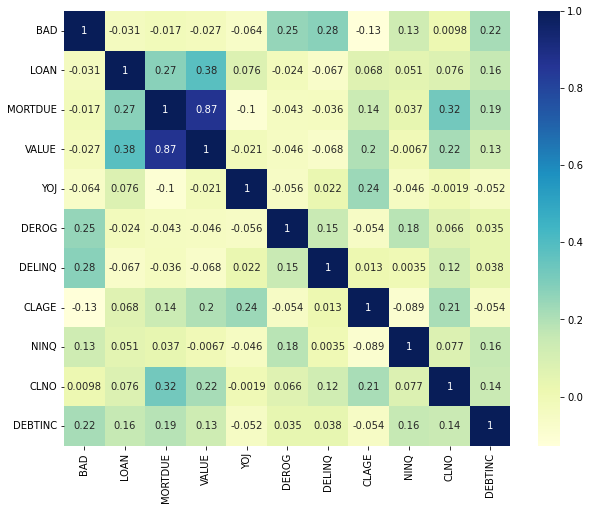

In [9]:
# your code here

# check to see the remaining variables
numeric_var = ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
cor = hmeq_data[numeric_var].corr()
# # plot heat map
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True,cmap="YlGnBu", ax=ax)
hmeq_data_loan = hmeq_data.drop(['MORTDUE'], axis = 1)
hmeq_data_loan.info()

Between MORTDUE and VALUE, drop MORTDUE as it has a lower correlation to BAD than VALUE has to BAD. We want to drop highly correlated variables as it clutters the model - the model gets confused in attributing which variable causes BAD.

## 2. Logistic Regression
Now we can apply a logistic regression model to the data.

#### Do a simple test of logistic regression on a subset of the data

Perform logistic regression on the LOAN variable

In [10]:
# sample code

# X are the independent variables, y is the dependent variable
X = hmeq_data[['LOAN']]
y = hmeq_data['BAD']

# create a logistic regression model and fit the training data
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)

# make it easlier to view the output coefficients
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])
pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())

C:\Users\Faez\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Intercept    0.187572
LOAN        -0.000010
dtype: float64

Plot the regession sigmoid curve versus the data

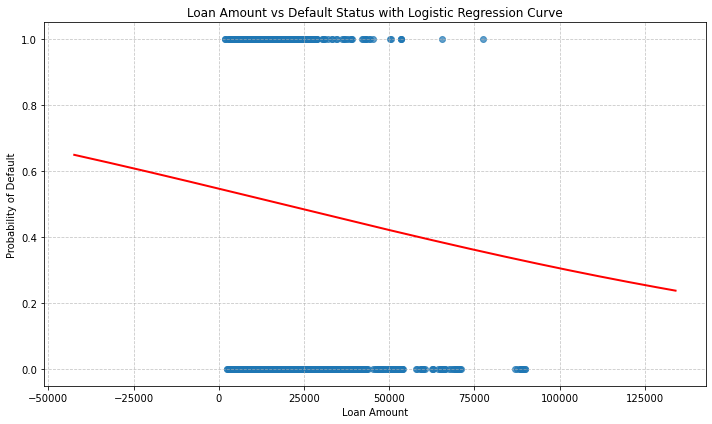

In [11]:
intercept = logreg.intercept_
loan_coef = logreg.coef_.reshape(-1)

# set figure size
plt.figure(figsize=(10, 6))

# create scatterplot
plt.scatter(hmeq_data['LOAN'], hmeq_data['BAD'], alpha=0.7)

# define sigmoid function
def sigmoid(x):
    z = intercept + loan_coef * x
    # to avoid numerical issues with large negative/positive values
    return np.exp(z) / (1 + np.exp(z))

# generate x values across a wider range to show the sigmoid shape
# using a much wider range than just the data range
x_min = hmeq_data['LOAN'].min()
x_max = hmeq_data['LOAN'].max()
x_range = np.linspace(x_min - 0.5 * (x_max - x_min), x_max + 0.5 * (x_max - x_min), 1000)

y_pred = sigmoid(x_range)

# plot the sigmoid curve
plt.plot(x_range, y_pred, 'r-', linewidth=2)

# add labels and title
plt.xlabel('Loan Amount')
plt.ylabel('Probability of Default')
plt.title('Loan Amount vs Default Status with Logistic Regression Curve')

# add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# show plot
plt.tight_layout()
plt.show()

**Ex Q3: perform logistic regression on the DELINQ variable**

Perform logistic regression on the DELINQ variable

In [41]:
hmeq_data_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3363 entries, 5 to 5959
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3363 non-null   int64  
 1   LOAN     3363 non-null   int64  
 2   VALUE    3363 non-null   float64
 3   YOJ      3363 non-null   float64
 4   DEROG    3363 non-null   float64
 5   DELINQ   3363 non-null   float64
 6   CLAGE    3363 non-null   float64
 7   NINQ     3363 non-null   float64
 8   CLNO     3363 non-null   float64
 9   DEBTINC  3363 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 289.0 KB


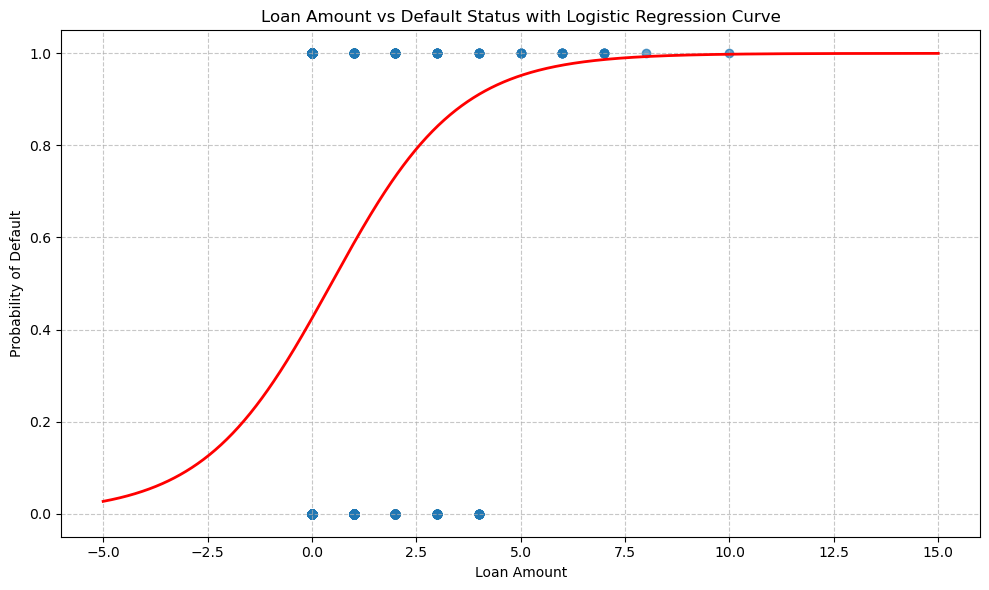

In [39]:
#logreg

# X are the independent variables, y is the dependent variable
X = hmeq_data_loan[['DELINQ']]
y = hmeq_data_loan['BAD']

# create a logistic regression model and fit the training data
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)

# make it easlier to view the output coefficients
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])
pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())

intercept = logreg.intercept_
loan_coef = logreg.coef_.reshape(-1)

# set figure size
plt.figure(figsize=(10, 6))

# create scatterplot
plt.scatter(hmeq_data_loan['DELINQ'], hmeq_data_loan['BAD'], alpha=0.7)

# define sigmoid function
def sigmoid(x):
    z = intercept + loan_coef * x
    # to avoid numerical issues with large negative/positive values
    return np.exp(z) / (1 + np.exp(z))

# generate x values across a wider range to show the sigmoid shape
# using a much wider range than just the data range
x_min = hmeq_data_loan['DELINQ'].min()
x_max = hmeq_data_loan['DELINQ'].max()
x_range = np.linspace(x_min - 0.5 * (x_max - x_min), x_max + 0.5 * (x_max - x_min), 1000)

y_pred = sigmoid(x_range)

# plot the sigmoid curve
plt.plot(x_range, y_pred, 'r-', linewidth=2)

# add labels and title
plt.xlabel('Loan Amount')
plt.ylabel('Probability of Default')
plt.title('Loan Amount vs Default Status with Logistic Regression Curve')

# add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# show plot
plt.tight_layout()
plt.show()

Plot the regession versus the data

Ex Q3 questions to answer:
- Do increasing values raise or lower the probability of default for
    + LOAN
    + DELINQ
- Based on the regression, which variable do you think will be the better predictor? Why?

**Answer:** <br>
LOAN: LOWERS PROBABILITY OF DEFAULT
DELINQ: RAISES PROBABILITY OF DEFAULT

DELINQ IS A BETTER PREDICTOR, AS IT FOLLOWS A SIGMOID CURVE.

#### Do logistic regression using all of the variables


In [98]:
# sample code

# prepare data for logistic regression
X = hmeq_data_loan.drop('BAD', axis = 1)
y = hmeq_data_loan['BAD']

# create a logistic regression model and fit the training data
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)

# concatenate intercept and coefficients to a single array
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])

# create a pandas Series with the features corresponding to the coefficients
coeff_series = pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())
coeff_series


Intercept   -1.442885
LOAN        -0.000013
VALUE        0.000001
YOJ         -0.022933
DEROG        0.743004
DELINQ       0.755964
CLAGE       -0.005999
NINQ         0.134934
CLNO        -0.014175
DEBTINC      0.064492
dtype: float64

Calculate the probability of a new case being BAD using the logistic regression formula?:

![𝑃=1/(1+𝑒^(−(𝛽_0+𝛽_𝑖 𝑋_𝑖)))](<attachment:Screenshot 2025-03-13 at 10.26.12.png>)

New case values:
- LOAN = 1800
- VALUE = 40000
- YOJ = 9.5
- DEROG = 0
- DELINQ = 0
- CLAGE = 99
- NINQ = 1
- CLNO = 8
- DEBTINC = 38

In [101]:
# sample code 

# define the data as a dictionary
data = {
    'LOAN': 1800,
    'VALUE': 40000,
    'YOJ': 9.5,
    'DEROG': 0,
    'DELINQ': 0,
    'CLAGE': 99,
    'NINQ': 1,
    'CLNO': 8,
    'DEBTINC': 38
}

# compute the exponent value 
# start with the intercept
linear_combination = coeff[0]
# add the product of each of coefficients and corresponding data values
for key in data.keys():
    linear_combination += coeff_series[key] * data[key]

# compute the probability using the logistic regression formula
probability = 1 / (1 + np.exp(-linear_combination))
pred_status = int(probability > 0.5)

print(f'probability = {probability:.3f}, predicted_status = {pred_status}')


probability = 0.561, predicted_status = 1


Alternatively, use the logreg functions to predict the probability and status

In [104]:
# create a dataframe to input to predict_proba
data_df = pd.DataFrame([data])

# use the logreg logreg functions to predict the probability and status
logreg_prob = logreg.predict_proba(data_df)[0][1]
logreg_pred_status = logreg.predict(data_df)
print(f'probability = {logreg_prob:.3f}, predicted_status = {logreg_pred_status[0]}')


probability = 0.561, predicted_status = 1


Calculate the the model's accuracy

In [107]:
# predict class labels
y_pred = logreg.predict(X)

# convert actual y values to array for comparison with predicted values
y_array = y.to_numpy() 

# compute accuracy
# first, calcuate how many predicted values match the actual values
correct_predictions = sum(y_pred[i] == y_array[i] for i in range(len(y)))

# then, calculate the accurate predictions as a percentage of the total
accuracy = correct_predictions / len(y)
print(f'Model accuracy: {accuracy:.4}')

Model accuracy: 0.7782


Alternatively, we can use the sklearn accuracy_score function to calculate accuracy

In [110]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y, y_pred)
print(f'Model accuracy (VALUE variable): {accuracy:.4}')

Model accuracy (VALUE variable): 0.7782


**DIY Q1:**

From the original hmeq_data data set, create new data sets that include either the VALUE or the MORTDUE variable. 
- Is the model accuracy better or worse with one, the other, or both?

In [131]:
hmeq_data_mortdue = hmeq_data.drop('VALUE', axis = 1)
# test mortdue data only
X = hmeq_data_mortdue.drop('BAD', axis = 1)
y = hmeq_data_mortdue['BAD']

logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])
coeff_series = pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())

data = {
    'LOAN': 1800,
    'MORTDUE': 40000,
    'YOJ': 9.5,
    'DEROG': 0,
    'DELINQ': 0,
    'CLAGE': 99,
    'NINQ': 1,
    'CLNO': 8,
    'DEBTINC': 38
}

data_df = pd.DataFrame([data])
logreg_prob = logreg.predict_proba(data_df)[0][1]
logreg_pred_status = logreg.predict(data_df)
print(f'probability = {logreg_prob:.3f}, predicted_status = {logreg_pred_status[0]}')

y_pred = logreg.predict(X)
y_array = y.to_numpy() 
correct_predictions = sum(y_pred[i] == y_array[i] for i in range(len(y)))
accuracy = correct_predictions / len(y)
print(f'Model accuracy (without VALUE variable): {accuracy:.4}')

# test both dataset
X = hmeq_data.drop('BAD', axis = 1)
y = hmeq_data['BAD']

logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])
coeff_series = pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())

data = {
    'LOAN': 1800,
    'MORTDUE': 40000,
    'VALUE': 100000,
    'YOJ': 9.5,
    'DEROG': 0,
    'DELINQ': 0,
    'CLAGE': 99,
    'NINQ': 1,
    'CLNO': 8,
    'DEBTINC': 38
}

data_df = pd.DataFrame([data])
logreg_prob = logreg.predict_proba(data_df)[0][1]
logreg_pred_status = logreg.predict(data_df)
print(f'probability = {logreg_prob:.3f}, predicted_status = {logreg_pred_status[0]}')

y_pred = logreg.predict(X)
y_array = y.to_numpy() 
correct_predictions = sum(y_pred[i] == y_array[i] for i in range(len(y)))
accuracy = correct_predictions / len(y)
print(f'Model accuracy (with both variables): {accuracy:.4}')

probability = 0.566, predicted_status = 1
Model accuracy (without VALUE variable): 0.7767
probability = 0.580, predicted_status = 1
Model accuracy (with both variables): 0.7779


**Answer:** The model is most accurate without the MORTDUE variable, at 0.7782 accuracy. 

**DIY Q2:**

- Review the variables and identify two which you believe could be more useful when combined, as a ratio or difference, rather than as separate variables. Explain your reasoning for creating this extracted variable.
- From the original hmeq_data data set, add the extracted variable to the data set and remove the original two variables.  Calculate the accuracy of the module with the extracted variable and compare with the accuracy using the original two variables. Which is better?



In [123]:
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3363 entries, 5 to 5959
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3363 non-null   int64  
 1   LOAN     3363 non-null   int64  
 2   MORTDUE  3363 non-null   float64
 3   VALUE    3363 non-null   float64
 4   YOJ      3363 non-null   float64
 5   DEROG    3363 non-null   float64
 6   DELINQ   3363 non-null   float64
 7   CLAGE    3363 non-null   float64
 8   NINQ     3363 non-null   float64
 9   CLNO     3363 non-null   float64
 10  DEBTINC  3363 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 315.3 KB


**Answer:** I believe that you can combine MORTDUE and VALUE, as a ratio (MORTDUE/VALUE). By doing so, we can understand the mortgage due against the value of the property, to understand how much home equity an applicant has. Even as the value of the property fluctuates, we can better understand the fluctuating home equity of an applicant, hence gaining a better judgement of risk against shifting market conditions.


**DIY Q3:**

To make the model and probability calculation simpler, we want to reduce the number of variables used by the model from 8 to 6. 

Determine which two variables will have the least impact on the predictive accuracy of the model, remove them and then calculate the how much the model's accuracy has changed. 

How did you determine which two variables to drop?

In [137]:
# your code here
X = hmeq_data.drop(['BAD', 'NINQ', 'YOJ'], axis = 1)
y = hmeq_data['BAD']
print(X)
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])
coeff_series = pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())

data = {
    'LOAN': 1800,
    'MORTDUE': 40000,
    'VALUE': 100000,
    'DEROG': 0,
    'DELINQ': 0,
    'CLAGE': 99,
    'CLNO': 8,
    'DEBTINC': 38
}

data_df = pd.DataFrame([data])
logreg_prob = logreg.predict_proba(data_df)[0][1]
logreg_pred_status = logreg.predict(data_df)
print(f'probability = {logreg_prob:.3f}, predicted_status = {logreg_pred_status[0]}')

y_pred = logreg.predict(X)
y_array = y.to_numpy() 
correct_predictions = sum(y_pred[i] == y_array[i] for i in range(len(y)))
accuracy = correct_predictions / len(y)
print(f'Model accuracy (with both variables): {accuracy:.4}')



       LOAN   MORTDUE     VALUE  DEROG  DELINQ       CLAGE  CLNO    DEBTINC
5      1700   30548.0   40320.0    0.0     0.0  101.466002   8.0  37.113614
7      1800   28502.0   43034.0    0.0     0.0   88.766030   8.0  36.884894
19     2300  102370.0  120953.0    0.0     0.0   90.992533  13.0  31.588503
25     2400   34863.0   47471.0    0.0     0.0   70.491080  21.0  38.263601
26     2400   98449.0  117195.0    0.0     0.0   93.811775  13.0  29.681827
...     ...       ...       ...    ...     ...         ...   ...        ...
5955  88900   57264.0   90185.0    0.0     0.0  221.808718  16.0  36.112347
5956  89000   54576.0   92937.0    0.0     0.0  208.692070  15.0  35.859971
5957  89200   54045.0   92924.0    0.0     0.0  212.279697  15.0  35.556590
5958  89800   50370.0   91861.0    0.0     0.0  213.892709  16.0  34.340882
5959  89900   48811.0   88934.0    0.0     0.0  219.601002  16.0  34.571519

[3363 rows x 8 columns]
probability = 0.584, predicted_status = 1
Model accuracy (with 

**Answer:**
- Variables removed: NINQ and YOJ
- Accuracy reduced by: 0.7782 - 0.7749 = 0.0033
- How chose variables to drop: NINQ only counts the recent number of inquiries, which may not lead to a loan, and hence is not particularly useful in determining risk - it does, however, indicates the level of financial distress. CLNO already gives us information on an applicant's existing loans. While YOJ suggests job stability, DEBTINC directly gives us a better idea of whether an applicant can service their future loan. 

# Group Assignment Preparation
Based on the group assignment data, answer the DYI question below.

**DYI Q4: Preparing the bureau data for merging**

To combine the bureau data with the application data you will need to "flatten" the multiple rows associated with each application ID (SK_ID_CURR) into a single row. <BR>
It will also be helpful if you can reduce the number of columns in the bureau data that will need to be merged.
- Based on the data dictionary definitions and the inspection of the bureau data, explain how you would propose to do feature engineering on all of the bureau variables so that they can be condensed to one value per application ID.
- Calculate the correlation between the bureau variables and use that information to further propose how columns could potentially be combined or dropped.

Put your code and answers below, and prepare to discuss in class next week.

In [148]:
# your code here
bureau_data = pd.read_csv("IS453 Group Assignment - Bureau Data.csv")
bureau_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   DAYS_CREDIT             int64  
 1   CREDIT_DAY_OVERDUE      int64  
 2   DAYS_CREDIT_ENDDATE     float64
 3   DAYS_ENDDATE_FACT       float64
 4   AMT_CREDIT_MAX_OVERDUE  float64
 5   CNT_CREDIT_PROLONG      int64  
 6   AMT_CREDIT_SUM          float64
 7   AMT_CREDIT_SUM_DEBT     float64
 8   AMT_CREDIT_SUM_LIMIT    float64
 9   AMT_CREDIT_SUM_OVERDUE  float64
 10  DAYS_CREDIT_UPDATE      int64  
 11  AMT_ANNUITY             float64
dtypes: float64(8), int64(4)
memory usage: 157.1 MB


<Axes: >

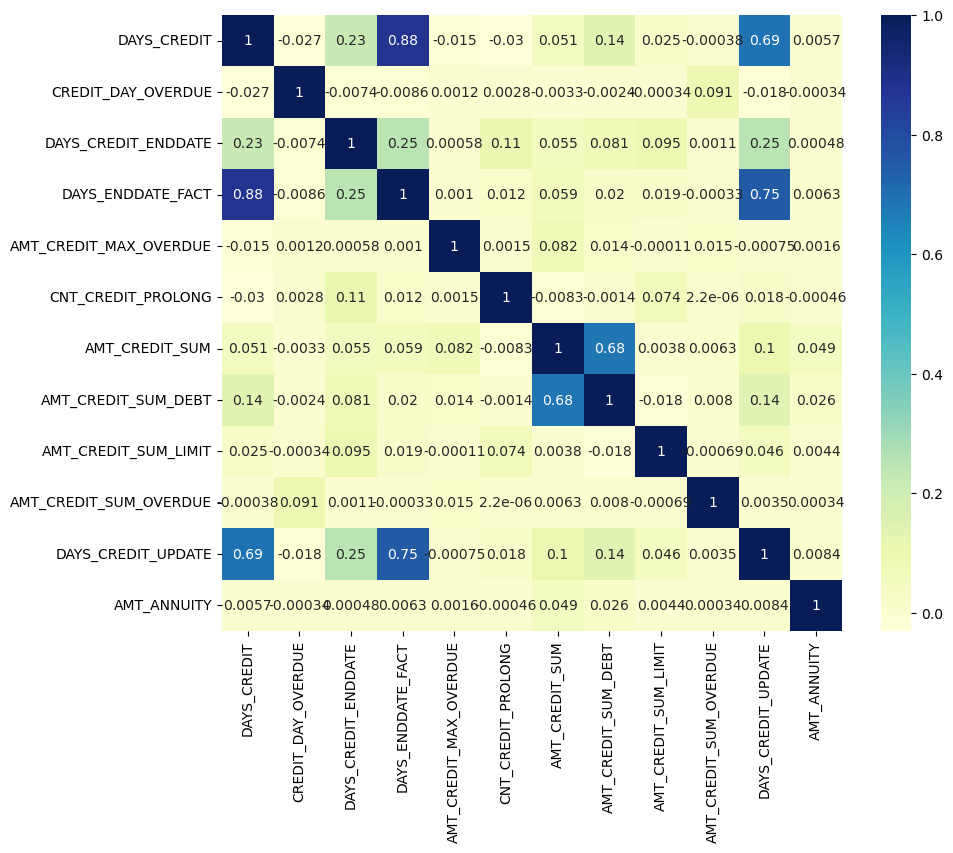

In [158]:
# bureau_data.head()
bureau_numeric = bureau_data.drop(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], axis = 1)
bureau_numeric.info()
cor = bureau_numeric.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True,cmap="YlGnBu", ax=ax)

**Answer:** I would aggregate the bureau information. For instance, combining rows with active and closed credit lines, and replacing the 'CREDIT_ACTIVE' column with 'CREDIT_ACTIVE_RATIO', which is the count of active credit lines against closed credit lines. As for highly correlated variables, between DAYS_CREDIT and DAYS_ENDDATE_FACT, I would keep DAYS_CREDIT. DAYS_CREDIT is always available for all past loans, whereas DAYS_ENDDATE_FACT is only available for closed loans. DAYS_ENDDATE_FACT is therefore a subset of DAYS_CREDIT and can be removed.